In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
import itertools
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots


class NKModel:
    """
    Implementation of the NK Model for creating tunable fitness landscapes.
    
    Attributes:
        N (int): Number of genes in the genome
        K (int): Number of other genes each gene interacts with (epistasis parameter)
        interaction_matrix (np.ndarray): Matrix defining which genes interact with each other
        contribution_tables (list): Fitness contribution tables for each gene
        
    Methods:
        generate_random_interaction_matrix(): Creates a random interaction matrix
        generate_contribution_tables(): Creates random fitness contribution tables
        calculate_fitness(genome): Calculates fitness for a given genome
        generate_fitness_landscape(): Generates the complete fitness landscape
        find_local_optima(): Identifies all local optima in the landscape
        get_neighbors(genome): Gets all one-bit mutation neighbors of a genome
        visualize_landscape(): Visualizes the fitness landscape
        analyze_landscape_ruggedness(): Analyzes the ruggedness by counting local optima
    """
        
    def __init__(self, N, K, seed=None):
            """
            Initialize the NK Model.
            
            Args:
                N (int): Number of genes in the genome
                K (int): Number of other genes each gene interacts with (0 <= K < N)
                seed (int, optional): Random seed for reproducibility
            """
            if K >= N:
                raise ValueError(f"K must be less than N. Got K={K}, N={N}")
            
            self.N = N
            self.K = K
            self.rng = np.random.RandomState(seed)
            
            # Generate interaction matrix and contribution tables
            self.interaction_matrix = self.generate_random_interaction_matrix()
            self.contribution_tables = self.generate_contribution_tables()
            
            # Cache for fitness values to avoid recalculation
            self.fitness_cache = {}

    def generate_random_interaction_matrix(self):
        """
        Generate a random interaction matrix where each gene interacts with K other genes.
        
        Returns:
            np.ndarray: An N x (K+1) matrix where each row i contains the indices of 
                        genes that affect gene i (including i itself)
        """
        interaction_matrix = np.zeros((self.N, self.K + 1), dtype=int)
        
        for i in range(self.N):
            # Each gene always interacts with itself
            interaction_matrix[i, 0] = i
            
            # Select K other genes randomly
            other_genes = [j for j in range(self.N) if j != i]
            selected = self.rng.choice(other_genes, self.K, replace=False)
            interaction_matrix[i, 1:] = selected
            
        return interaction_matrix
    
    def generate_contribution_tables(self):
        """
        Generate random fitness contribution tables for each gene.
        
        Returns:
            list: A list of 2^(K+1) fitness contributions for each gene
        """
        contribution_tables = []
        
        for i in range(self.N):
            # Create a table for each possible state of the gene and its K interacting genes
            # There are 2^(K+1) possible states
            table = self.rng.random(2**(self.K + 1))
            contribution_tables.append(table)
            
        return contribution_tables
    
    def calculate_fitness(self, genome):
        """
        Calculate the fitness of a genome based on the NK model.
        
        Args:
            genome (np.ndarray or list): Binary genome of length N (0s and 1s)
            
        Returns:
            float: The fitness value of the genome
        """
        # Convert genome to tuple for caching
        genome_tuple = tuple(genome)
        
        # Return cached value if available
        if genome_tuple in self.fitness_cache:
            return self.fitness_cache[genome_tuple]
        
        fitness_contributions = []
        
        for i in range(self.N):
            # Get the state of gene i and its interacting genes
            interacting_genes = self.interaction_matrix[i]
            state = [genome[j] for j in interacting_genes]
            
            # Convert state to an index for the contribution table
            # Example: state [1,0,1] becomes 1*2^0 + 0*2^1 + 1*2^2 = 5
            index = sum(state[j] * (2 ** j) for j in range(len(state)))
            
            # Get the fitness contribution for this state
            contribution = self.contribution_tables[i][index]
            fitness_contributions.append(contribution)
        
        # Calculate overall fitness as the average of all contributions
        fitness = sum(fitness_contributions) / self.N
        
        # Cache the result
        self.fitness_cache[genome_tuple] = fitness
        
        return fitness
    
    def generate_fitness_landscape(self):
        """
        Generate the complete fitness landscape for all possible genomes.
        
        Returns:
            dict: A dictionary mapping genome tuples to fitness values
        """
        landscape = {}
        
        # Generate all possible binary genomes of length N
        all_genomes = list(itertools.product([0, 1], repeat=self.N))
        
        # Calculate fitness for each genome
        for genome in tqdm(all_genomes, desc=f"Generating landscape for K={self.K}"):
            landscape[genome] = self.calculate_fitness(genome)
            
        return landscape
    
    def get_neighbors(self, genome):
        """
        Get all one-bit mutation neighbors of a genome.
        
        Args:
            genome (tuple): The genome as a tuple
            
        Returns:
            list: List of neighbor genomes (as tuples)
        """
        neighbors = []
        
        for i in range(self.N):
            # Create a new genome with the i-th bit flipped
            neighbor = list(genome)
            neighbor[i] = 1 - neighbor[i]  # Flip 0 to 1 or 1 to 0
            neighbors.append(tuple(neighbor))
            
        return neighbors
    
    def find_local_optima(self, landscape=None):
        """
        Find all local optima in the fitness landscape.
        
        Args:
            landscape (dict, optional): Pre-generated fitness landscape
            
        Returns:
            list: List of genome tuples that are local optima
        """
        if landscape is None:
            landscape = self.generate_fitness_landscape()
            
        local_optima = []
        
        for genome, fitness in landscape.items():
            # Get all neighbors
            neighbors = self.get_neighbors(genome)
            
            # Check if this genome has higher fitness than all neighbors
            is_local_optimum = True
            for neighbor in neighbors:
                if landscape[neighbor] > fitness:
                    is_local_optimum = False
                    break
                    
            if is_local_optimum:
                local_optima.append(genome)
                
        return local_optima
    
    def analyze_landscape_ruggedness(self, num_samples=None):
        """
        Analyze the ruggedness of the landscape by counting local optima.
        
        Args:
            num_samples (int, optional): Number of random genomes to sample for fitness
            
        Returns:
            dict: Dictionary containing metrics about landscape ruggedness
        """
        # Generate the complete landscape if it's small enough
        if self.N <= 16:  # 2^16 = 65,536 genomes
            landscape = self.generate_fitness_landscape()
            local_optima = self.find_local_optima(landscape)
            
            # Calculate average fitness
            avg_fitness = sum(landscape.values()) / len(landscape)
            
            # Calculate fitness correlation
            fitnesses = list(landscape.values())
            mean_fitness = np.mean(fitnesses)
            std_fitness = np.std(fitnesses)
            
            return {
                'num_local_optima': len(local_optima),
                'fraction_local_optima': len(local_optima) / len(landscape),
                'avg_fitness': avg_fitness,
                'fitness_std': std_fitness
            }
        else:
            # For large N, sample the landscape
            if num_samples is None:
                num_samples = min(10000, 2**self.N)
                
            # Sample random genomes
            samples = []
            for _ in range(num_samples):
                genome = tuple(self.rng.randint(0, 2, self.N))
                samples.append((genome, self.calculate_fitness(genome)))
                
            # Calculate average fitness
            avg_fitness = sum(f for _, f in samples) / len(samples)
                
            return {
                'avg_fitness': avg_fitness,
                'note': 'Full landscape analysis not performed due to large N'
            }
    
    def visualize_landscape(self, max_dims=2):
        """
        Visualize the fitness landscape for small N.
        
        Args:
            max_dims (int): Maximum number of dimensions to visualize (1 or 2)
            
        Returns:
            matplotlib.figure.Figure: The plot figure
        """
        if self.N > max_dims:
            print(f"WARNING: N={self.N} is too large to visualize directly. Showing projection.")
        
        if max_dims == 1:
            # 1D visualization (for N=1)
            fig, ax = plt.subplots(figsize=(10, 6))
            
            genomes = [(0,), (1,)]
            fitnesses = [self.calculate_fitness(g) for g in genomes]
            
            ax.bar([0, 1], fitnesses)
            ax.set_xlabel('Genome')
            ax.set_ylabel('Fitness')
            ax.set_title(f'NK Model Fitness Landscape (N={self.N}, K={self.K})')
            ax.set_xticks([0, 1])
            ax.set_xticklabels(['0', '1'])
            
        elif max_dims == 2:
            if self.N >= 2:
                # 2D visualization (for N=2 or projection of higher dims)
                fig, ax = plt.subplots(figsize=(10, 8))
                
                # For N=2, visualize the complete landscape
                if self.N == 2:
                    # Generate all 4 possible genomes
                    x = np.array([0, 0, 1, 1])
                    y = np.array([0, 1, 0, 1])
                    genomes = [(x[i], y[i]) for i in range(4)]
                    fitnesses = [self.calculate_fitness(g) for g in genomes]
                    
                    # 3D surface plot
                    ax = fig.add_subplot(111, projection='3d')
                    ax.plot_trisurf(x, y, fitnesses, cmap=cm.viridis, linewidth=0.2)
                    ax.set_xlabel('Gene 1')
                    ax.set_ylabel('Gene 2')
                    ax.set_zlabel('Fitness')
                    ax.set_title(f'NK Model Fitness Landscape (N={self.N}, K={self.K})')
                    
                # For N>2, create a heatmap projection
                else:
                    # Generate all combinations of the first two genes
                    x_vals = np.array([0, 0, 1, 1])
                    y_vals = np.array([0, 1, 0, 1])
                    
                    # For each combination, generate multiple random configurations of other genes
                    # and calculate average fitness
                    z = np.zeros((2, 2))
                    samples_per_cell = 50
                    
                    for i, x in enumerate([0, 1]):
                        for j, y in enumerate([0, 1]):
                            avg_fitness = 0
                            for _ in range(samples_per_cell):
                                # Generate random values for the other N-2 genes
                                other_genes = self.rng.randint(0, 2, self.N - 2)
                                genome = np.array([x, y, *other_genes])
                                avg_fitness += self.calculate_fitness(genome)
                            z[i, j] = avg_fitness / samples_per_cell
                    
                    # Create heatmap
                    sns.heatmap(z, annot=True, fmt=".3f", cmap="viridis", 
                              xticklabels=[0, 1], yticklabels=[0, 1],
                              cbar_kws={'label': 'Average Fitness'})
                    ax.set_xlabel('Gene 2')
                    ax.set_ylabel('Gene 1')
                    ax.set_title(f'NK Model Average Fitness Projection (N={self.N}, K={self.K})')
            else:
                # Fallback to 1D for N=1
                return self.visualize_landscape(max_dims=1)
                
        plt.tight_layout()
        return fig

def analyze_NK_model_ruggedness(N, K_values, num_runs=5, seed=42):
    """
    Analyze how landscape ruggedness changes with different K values.
    
    Args:
        N (int): Number of genes
        K_values (list): List of K values to test
        num_runs (int): Number of runs for each K value
        seed (int): Random seed for reproducibility
        
    Returns:
        dict: Dictionary with analysis results
    """
    results = {
        'K_values': K_values,
        'avg_local_optima': [],
        'avg_fitness': [],
        'local_optima_stderr': [],
        'fitness_stderr': []
    }
    
    for K in K_values:
        local_optima_counts = []
        avg_fitnesses = []
        
        for run in range(num_runs):
            # Create model with different seed for each run
            model = NKModel(N=N, K=K, seed=seed + run)
            
            # Analyze landscape
            analysis = model.analyze_landscape_ruggedness()
            
            if 'num_local_optima' in analysis:
                local_optima_counts.append(analysis['num_local_optima'])
            avg_fitnesses.append(analysis['avg_fitness'])
        
        # Calculate average metrics across runs
        if local_optima_counts:
            results['avg_local_optima'].append(np.mean(local_optima_counts))
            results['local_optima_stderr'].append(np.std(local_optima_counts) / np.sqrt(len(local_optima_counts)))
        else:
            results['avg_local_optima'].append(None)
            results['local_optima_stderr'].append(None)
            
        results['avg_fitness'].append(np.mean(avg_fitnesses))
        results['fitness_stderr'].append(np.std(avg_fitnesses) / np.sqrt(len(avg_fitnesses)))
    
    return results

def plot_ruggedness_analysis(results):
    """
    Plot the results of the ruggedness analysis.
    
    Args:
        results (dict): Results from analyze_NK_model_ruggedness
        
    Returns:
        matplotlib.figure.Figure: The plot figure
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot number of local optima vs K
    if results['avg_local_optima'][0] is not None:
        ax1.errorbar(results['K_values'], results['avg_local_optima'], 
                    yerr=results['local_optima_stderr'], fmt='-o')
        ax1.set_xlabel('K (Epistatic Interactions)')
        ax1.set_ylabel('Average Number of Local Optima')
        ax1.set_title('Landscape Ruggedness vs K')
        ax1.grid(True, alpha=0.3)
    else:
        ax1.text(0.5, 0.5, 'Local optima analysis not available for large N', 
                ha='center', va='center')
        ax1.set_title('Landscape Ruggedness (N too large)')
    
    # Plot average fitness vs K
    ax2.errorbar(results['K_values'], results['avg_fitness'], 
                yerr=results['fitness_stderr'], fmt='-o', color='orange')
    ax2.set_xlabel('K (Epistatic Interactions)')
    ax2.set_ylabel('Average Fitness')
    ax2.set_title('Average Fitness vs K')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def visualize_multiple_landscapes(N, K_values, seed=42):
    """
    Create visualization of landscapes with different K values.
    
    Args:
        N (int): Number of genes
        K_values (list): List of K values to visualize
        seed (int): Random seed for reproducibility
        
    Returns:
        matplotlib.figure.Figure: The plot figure
    """
    num_plots = len(K_values)
    fig = plt.figure(figsize=(5*num_plots, 5))
    
    for i, K in enumerate(K_values):
        model = NKModel(N=N, K=K, seed=seed)
        
        if N <= 2:
            # For N=1 or N=2, we can visualize exact landscape
            ax = fig.add_subplot(1, num_plots, i+1, projection='3d' if N==2 else None)
            
            if N == 1:
                genomes = [(0,), (1,)]
                fitnesses = [model.calculate_fitness(g) for g in genomes]
                ax.bar([0, 1], fitnesses)
                ax.set_xticks([0, 1])
                ax.set_xticklabels(['0', '1'])
                ax.set_xlabel('Gene Value')
                ax.set_ylabel('Fitness')
            else:  # N == 2
                x = np.array([0, 0, 1, 1])
                y = np.array([0, 1, 0, 1])
                genomes = [(x[i], y[i]) for i in range(4)]
                fitnesses = [model.calculate_fitness(g) for g in genomes]
                
                ax.plot_trisurf(x, y, fitnesses, cmap=cm.viridis, linewidth=0.2)
                ax.set_xlabel('Gene 1')
                ax.set_ylabel('Gene 2')
                ax.set_zlabel('Fitness')
                
            ax.set_title(f'K={K}')
        else:
            # For N>2, show heatmap projection
            ax = fig.add_subplot(1, num_plots, i+1)
            
            # Generate all combinations of the first two genes
            z = np.zeros((2, 2))
            samples_per_cell = 50
            
            for i1, x in enumerate([0, 1]):
                for j1, y in enumerate([0, 1]):
                    avg_fitness = 0
                    for _ in range(samples_per_cell):
                        # Generate random values for the other N-2 genes
                        other_genes = np.random.randint(0, 2, N - 2)
                        genome = np.array([x, y, *other_genes])
                        avg_fitness += model.calculate_fitness(genome)
                    z[i1, j1] = avg_fitness / samples_per_cell
            
            # Create heatmap
            sns.heatmap(z, annot=True, fmt=".3f", cmap="viridis", 
                      xticklabels=[0, 1], yticklabels=[0, 1],
                      cbar_kws={'label': 'Avg Fitness'}, ax=ax)
            ax.set_xlabel('Gene 2')
            ax.set_ylabel('Gene 1')
            ax.set_title(f'K={K} (Avg Fitness Projection)')
    
    plt.tight_layout()
    return fig


Analyzing NK model with N=11 and K values [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Generating landscape for K=9: 100%|██████████| 2048/2048 [00:00<00:00, 40623.76it/s]


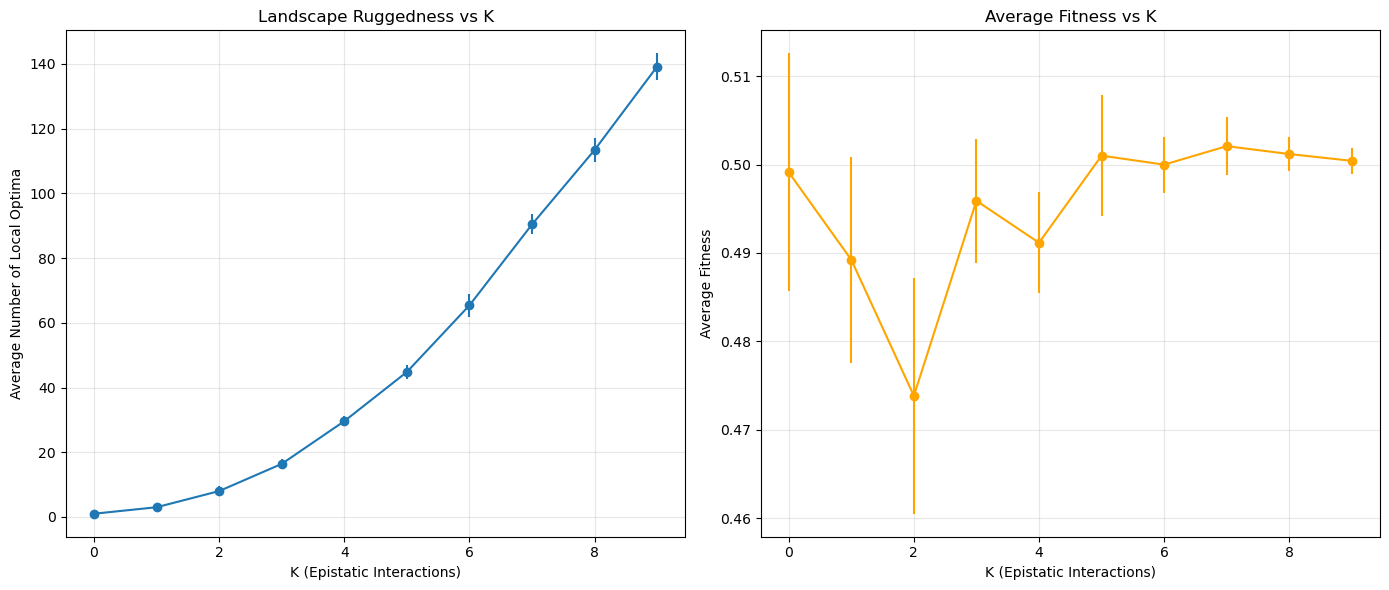

Visualizing landscapes with N=10 and K values [0, 2, 9]


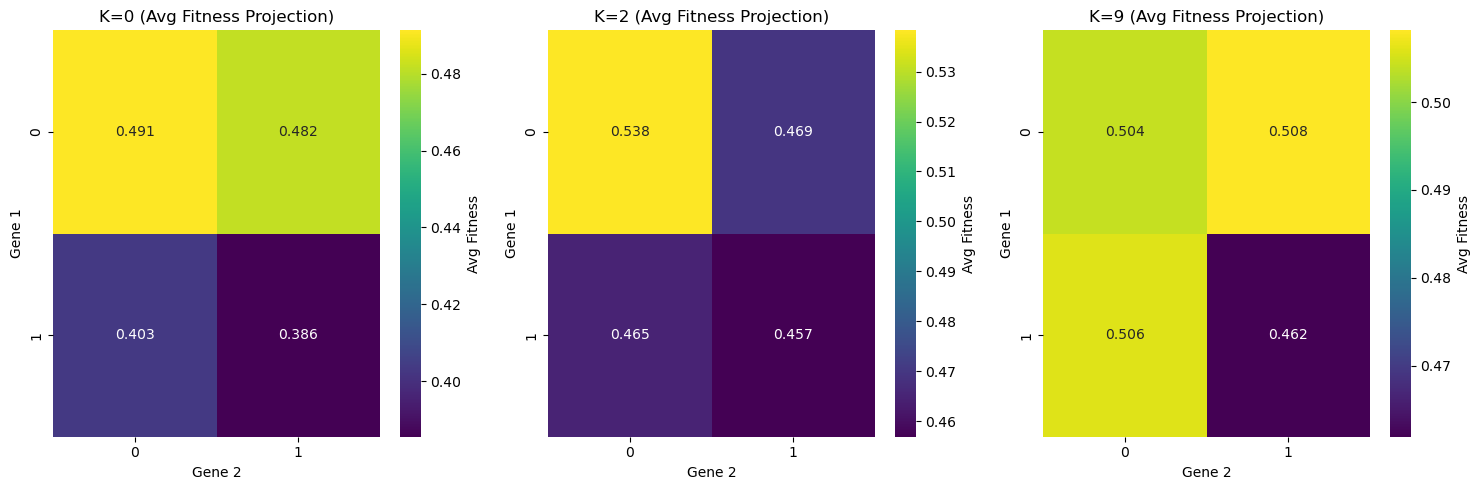

In [ ]:
# Main execution
if __name__ == "__main__":
    # Parameters
    N = 11  # Number of genes
    K_values = [0, 1, 2, 3, 4, 5 , 6, 7, 8, 9]  # Different K values to analyze
    
    # Analyze ruggedness for different K values
    print(f"Analyzing NK model with N={N} and K values {K_values}")
    results = analyze_NK_model_ruggedness(N, K_values)
    
    # Plot results
    fig1 = plot_ruggedness_analysis(results)
    plt.show()

    # For visualization, use a smaller N
    vis_N = 10
    vis_K_values = [0, 2, vis_N-1]
    
    print(f"Visualizing landscapes with N={vis_N} and K values {vis_K_values}")
    fig2 = visualize_multiple_landscapes(vis_N, vis_K_values)
    plt.show()
    

Analyzing NK model with N=16 and K values [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Generating landscape for K=9: 100%|██████████| 65536/65536 [00:02<00:00, 27660.44it/s]


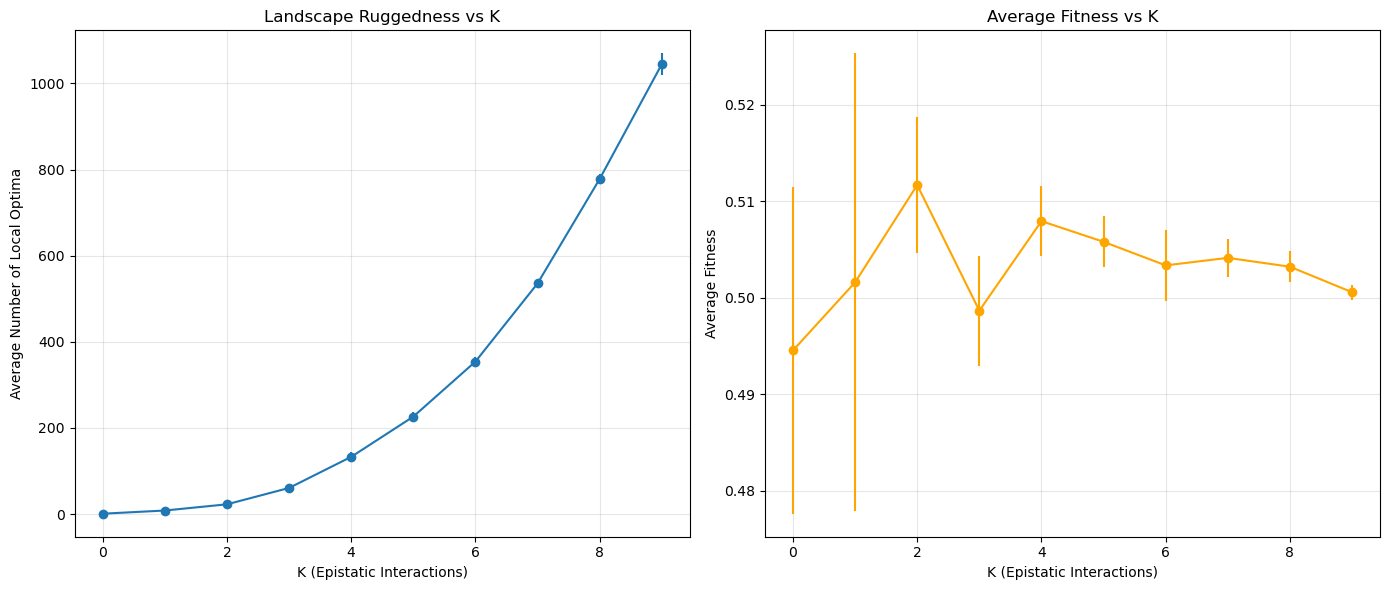

Visualizing landscapes with N=10 and K values [0, 2, 9]


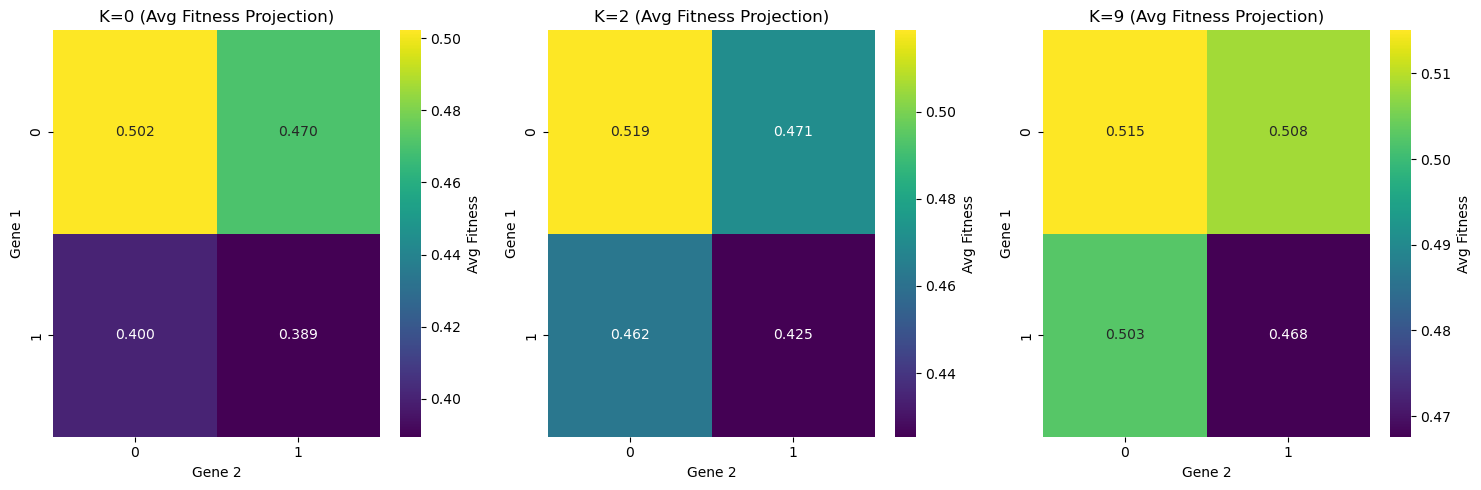

In [ ]:
# Main execution
if __name__ == "__main__":
    # Parameters
    N = 16  # Number of genes
    K_values = [0, 1, 2, 3, 4, 5 , 6, 7, 8, 9]  # Different K values to analyze
    
    # Analyze ruggedness for different K values
    print(f"Analyzing NK model with N={N} and K values {K_values}")
    results = analyze_NK_model_ruggedness(N, K_values)
    
    # Plot results
    fig1 = plot_ruggedness_analysis(results)
    plt.show()

    # For visualization, use a smaller N
    vis_N = 10
    vis_K_values = [0, 2, vis_N-1]
    
    print(f"Visualizing landscapes with N={vis_N} and K values {vis_K_values}")
    fig2 = visualize_multiple_landscapes(vis_N, vis_K_values)
    plt.show()
    